In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV

%matplotlib inline

df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

In [4]:
survived_train = df_train.Survived
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [5]:
data.Name.tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

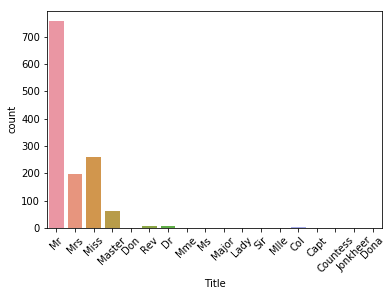

In [12]:
## Extracting a new feature
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

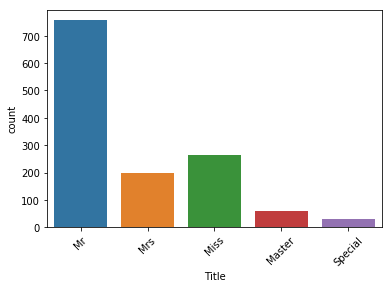

In [13]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir',
                                       'Col', 'Capt', 'Countess','Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

In [14]:
data['Has_Cabin'] = ~data.Cabin.isnull()

In [15]:
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


In [17]:
## Handling missing values
# data.info()

# Impute missing values for Age, Fare, Embarked
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1309 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1309 non-null float64
Embarked     1309 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [18]:
# Binning numerical columns

data['CatAge'] = pd.qcut(data.Age, q=4, labels=False)
data['CatFare'] = pd.qcut(data.Fare, q=4, labels=False)
data = data.drop(['Age', 'Fare'], axis=1)

In [20]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.Parch + data.SibSp
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,Pclass,Sex,Embarked,Title,Has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,3,1
4,3,male,S,Mr,False,2,1,0


In [21]:
# Transform into binary variables
data_dum = pd.get_dummies(data, drop_first=True)

## Building a predictive model with the new dataset

In [22]:
data_train = data_dum.iloc[:891]
data_test = data_dum.iloc[891:]

# Transform into arrays for sklearn
X = data_train.values
test = data_test.values
y = survived_train.values

In [24]:
param_grid = {
    'max_depth' : np.arange(1, 9)
}

clf = tree.DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, param_grid=param_grid)
clf_cv.fit(X, y)

print("Tuned Decision Tree Parameters : {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters : {'max_depth': 5}
Best score is 0.8215488215488216


In [30]:
Y_pred = clf_cv.predict(test)
df_test['Survived'] = Y_pred
df_test[['PassengerId', 'Survived']].to_csv('predictions.csv', index=False)